# Conjunto de datos Oxford-IIIT Pet

El conjunto de datos Oxford-IIIT Pet es un conjunto de datos ampliamente utilizado para tareas de segmentación semántica en visión por computadora. Contiene imágenes de gatos y perros de diferentes razas con etiquetas de segmentación.

## Descripción del conjunto de datos:

- Nombre del conjunto de datos: Oxford-IIIT Pet
- Versión: 3.2.0
- Creador: Universidad de Oxford y IIIT, Hyderabad
- Año de publicación: 2012
- Categoría: Imágenes de mascotas
- Número de clases: 37 (una para cada raza de mascota y una para el fondo)

## Contenido del conjunto de datos:

El conjunto de datos se divide en dos partes principales:

1. Conjunto de entrenamiento: Contiene imágenes de gatos y perros con etiquetas de segmentación que indican la ubicación de las mascotas en las imágenes.

2. Conjunto de prueba: Similar al conjunto de entrenamiento, pero se utiliza para evaluar el rendimiento de los modelos.

## Tamaño del conjunto de datos:

- Conjunto de entrenamiento: 3680 imágenes
- Conjunto de prueba: 3669 imágenes

## Formato de las etiquetas de segmentación:

Las etiquetas de segmentación son máscaras de píxeles que indican la ubicación de las mascotas en las imágenes. Cada píxel en la etiqueta tiene un valor que corresponde a la clase a la que pertenece (por ejemplo, raza de perro o gato).

## Uso del conjunto de datos:

El conjunto de datos Oxford-IIIT Pet se utiliza comúnmente en tareas de segmentación semántica y reconocimiento de mascotas en imágenes. Es una excelente elección para experimentar con modelos de segmentación semántica y prácticas de aprendizaje profundo.

## Descarga del conjunto de datos:

Puedes descargar el conjunto de datos Oxford-IIIT Pet utilizando la biblioteca `tensorflow_datasets` en TensorFlow. A continuación, se muestra un ejemplo de cómo cargar el conjunto de datos en Python:

```python
import tensorflow_datasets as tfds

# Cargar el conjunto de datos Oxford-IIIT Pet
dataset, info = tfds.load("oxford_iiit_pet:3.2.0", with_info=True)

# Acceder a las particiones del conjunto de datos
train_dataset = dataset["train"]
test_dataset = dataset["test"]


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

* En el ejercicio proporcionado, el modelo de segmentación semántica, específicamente el modelo U-Net, está diseñado para predecir una máscara de segmentación binaria que etiqueta las regiones de interés en las imágenes del conjunto de datos "Oxford-IIIT Pet". En este contexto, "regiones de interés" se refiere a las partes de la imagen que pertenecen a una clase específica: la clase de los objetos o mascotas en las imágenes. Por lo tanto, el modelo está prediciendo si cada píxel de una imagen pertenece a la clase de mascotas (etiqueta 1) o no (etiqueta 0).

* En otras palabras, el objetivo del modelo U-Net en este ejercicio es segmentar las imágenes para identificar y delimitar las áreas que contienen mascotas (como perros o gatos) en contraste con el fondo o áreas no relacionadas con mascotas. El modelo produce una máscara de segmentación binaria que indica las ubicaciones de las mascotas en la imagen.

In [36]:
# Clase para la Segmentación Semántica
class SemanticSegmentationClass:
    def __init__(self, img_size, n_classes):
        self.img_size = img_size
        self.n_classes = n_classes

    # Método para cargar y explorar el conjunto de datos Oxford-IIIT Pet Dataset
    def load_and_explore_dataset(self):
        dataset, info = tfds.load("oxford_iiit_pet:3.2.0", with_info=True)
        train_dataset = dataset["train"]

        # Mostrar información sobre el conjunto de datos
        print(info)

        # Ejemplo: visualizar una imagen y su etiqueta
        for example in train_dataset.take(1):
            image = example["image"]
            label = example["segmentation_mask"]

            # Visualizar la imagen y su etiqueta
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Imagen")
            plt.axis("off")
            plt.subplot(1, 2, 2)
            plt.imshow(label[:, :, 0])
            plt.title("Etiqueta de segmentación")
            plt.axis("off")
            plt.show()

    # Método para crear un generador de datos personalizado
    def create_data_generator(self, dataset, batch_size):
        # Función de preprocesamiento de las imágenes y etiquetas
        def preprocess_image(image, label):
            # Redimensionar la imagen a la forma que el modelo espera (128x128)
            image = tf.image.resize(image, (128, 128))
            label = tf.image.resize(label, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            # Normalizar las imágenes (escalar a [0, 1])
            image = tf.image.convert_image_dtype(image, tf.float32)
            label = tf.image.convert_image_dtype(label, tf.uint8)
            return image, label



        # Aplicar la función de preprocesamiento a todas las muestras
        dataset = dataset.map(lambda x: (preprocess_image(x["image"], x["segmentation_mask"])))

        # Establecer el tamaño de lote y habilitar el almacenamiento en búfer para una mejor eficiencia
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

        return dataset

    # Método para definir la arquitectura de U-Net con etiquetas de 1 canal
    def unet_model(self, input_shape, num_classes):
        inputs = Input(input_shape)

        # Capas de codificación
        conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        # Capas de expansión
        up3 = UpSampling2D(size=(2, 2))(pool2)
        up3 = Conv2D(64, 2, activation='relu', padding='same')(up3)
        up3 = UpSampling2D(size=(2, 2))(up3)  # Añadir otra capa UpSampling para que coincida con la resolución

        merge3 = concatenate([conv1, up3], axis=3)
        conv3 = Conv2D(64, 3, activation='relu', padding='same')(merge3)
        conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)

        # Capa de salida con un solo canal
        outputs = Conv2D(1, 1, activation='sigmoid')(conv3)

        model = Model(inputs=inputs, outputs=outputs)

        return model



    # Método para visualizar imágenes y predicciones
    def visualize_predictions(self, model, dataset, num_samples=1):
        for example in dataset.take(num_samples):
            image = example[0]
            label = example[1]

            # Realizar una predicción de segmentación semántica
            prediction = model.predict(tf.expand_dims(image, 0))

            # Visualizar la imagen, la etiqueta y la predicción
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Imagen")
            plt.axis("off")
            plt.subplot(1, 3, 2)
            plt.imshow(label[0, :, :, 0], cmap='gray')
            plt.title("Etiqueta de segmentación")
            plt.axis("off")
            plt.subplot(1, 3, 3)
            plt.imshow(prediction[0, :, :, 0], cmap='jet', alpha=0.7)
            plt.title("Predicción de segmentación")
            plt.axis("off")
            plt.show()

    # Método para crear y entrenar un modelo U-Net
    def train_unet_model(self, batch_size, epochs):
        # Cargar el conjunto de datos Oxford-IIIT Pet Dataset
        dataset, info = tfds.load("oxford_iiit_pet:3.2.0", with_info=True)
        train_dataset = dataset["train"]

        # Crear un generador de datos personalizado
        train_dataset = self.create_data_generator(train_dataset, batch_size)

        # Crear un modelo U-Net con etiquetas de 1 canal
        input_shape = self.img_size
        num_classes = 1  # Cambiar a 1 canal
        unet_model = self.unet_model(input_shape, num_classes)

        # Compilar el modelo con una función de pérdida adecuada
        unet_model.compile(optimizer=Adam(learning_rate=1e-4),
                           loss='binary_crossentropy',  # Cambiar a binary_crossentropy
                           metrics=['accuracy'])

        # Entrenar el modelo
        unet_model.fit(train_dataset, epochs=epochs)

    # Método para crear y entrenar un modelo DeepLab
    def train_deeplab_model(self, batch_size, epochs):
        # Cargar el conjunto de datos Oxford-IIIT Pet Dataset
        dataset, info = tfds.load("oxford_iiit_pet:3.2.0", with_info=True)
        train_dataset = dataset["train"]

        # Crear un generador de datos personalizado
        train_dataset = self.create_data_generator(train_dataset, batch_size)

        # Crear un modelo DeepLab
        input_shape = self.img_size
        num_classes = self.n_classes
        deeplab_model = self.deeplab_model(input_shape, num_classes)

        # Compilar el modelo
        deeplab_model.compile(optimizer=Adam(learning_rate=1e-4),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

        # Entrenar el modelo
        deeplab_model.fit(train_dataset, epochs=epochs)

In [28]:
import tensorflow as tf

# Cargamos el conjunto de datos Oxford-IIIT Pet Dataset
dataset, info = tfds.load("oxford_iiit_pet:3.2.0", with_info=True)
train_dataset = dataset["train"]

# Iteramos sobre las etiquetas y comprobamos sus dimensiones
for example in train_dataset.take(5):  # Cambia el número para ver más ejemplos si es necesario
    label = example["segmentation_mask"]
    print(f"Dimensiones de la etiqueta: {label.shape}")


Dimensiones de la etiqueta: (500, 500, 1)
Dimensiones de la etiqueta: (313, 500, 1)
Dimensiones de la etiqueta: (500, 333, 1)
Dimensiones de la etiqueta: (375, 500, 1)
Dimensiones de la etiqueta: (500, 333, 1)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

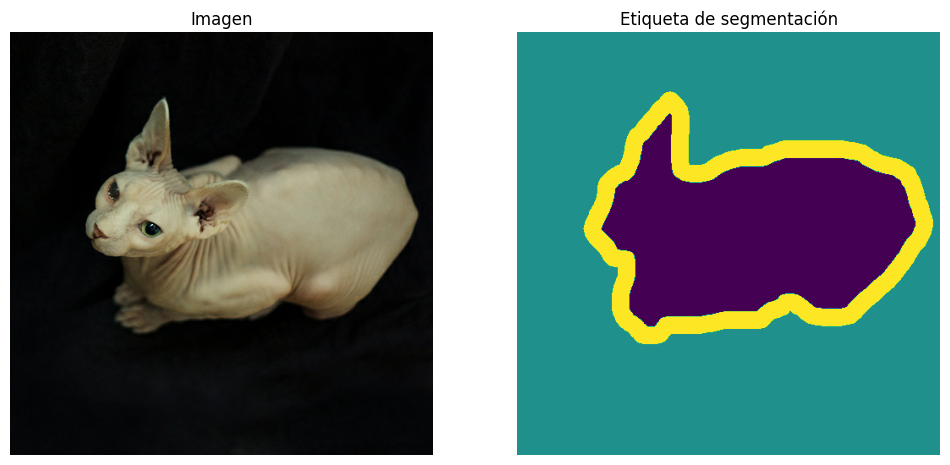

Epoch 1/3
230/230 [==============================] - 2032s 9s/step - loss: -44554809344.0000 - accuracy: 0.2996
Epoch 2/3
230/230 [==============================] - 2027s 9s/step - loss: -85656780931072.0000 - accuracy: 0.2996
Epoch 3/3
230/230 [==============================] - 2014s 9s/step - loss: -4806480184213504.0000 - accuracy: 0.2996
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        '

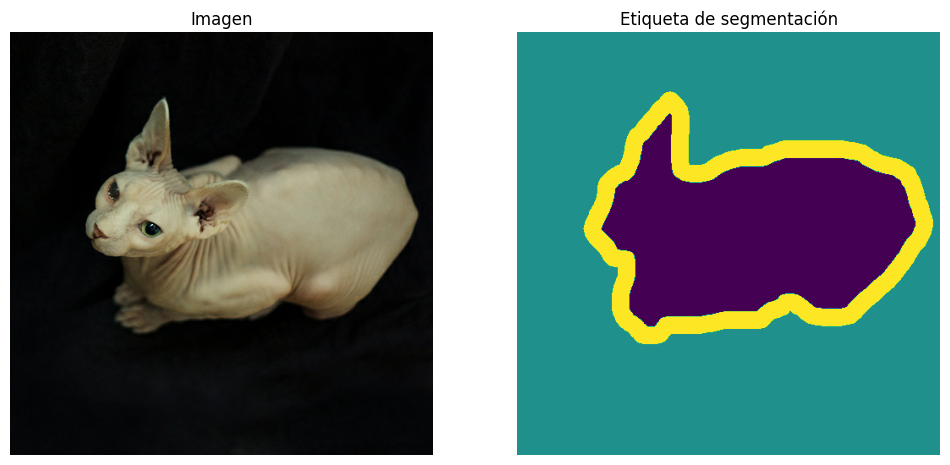

AttributeError: ignored

In [38]:
if __name__ == "__main__":
    img_size = (128, 128, 3)  # Tamaño de la imagen de entrada
    n_classes = 1  # Cambiar a 1 para etiquetas de 1 canal

    # Crear una instancia de la clase SemanticSegmentationClass
    segmentation_class = SemanticSegmentationClass(img_size, n_classes)

    # Cargar y explorar el conjunto de datos
    segmentation_class.load_and_explore_dataset()

    # Entrenar un modelo U-Net
    segmentation_class.train_unet_model(batch_size=16, epochs=3) #epochs = 10

    # Entrenar un modelo DeepLab
    # Asegúrate de que train_deeplab_model también esté adaptado a etiquetas de 1 canal si lo usas

    # Visualizar imágenes y predicciones
    dataset = segmentation_class.create_data_generator(segmentation_class.load_and_explore_dataset(), 1)
    segmentation_class.visualize_predictions(segmentation_class.unet_model, dataset)
